In [1]:
import os
import pandas as pd

base_folder = r"C:\Users\HP\Desktop\Dataset\Dataset"
csv_dataframes = {}

print(f"Starting to scan: {base_folder}")

for root, dirs, files in os.walk(base_folder):
    print(f"Scanning folder: {root}")
    for file in files:
        if file.endswith(".csv"):
            print(f"Found CSV: {file}")
            file_path = os.path.join(root, file)
            key_name = os.path.splitext(os.path.relpath(file_path, base_folder).replace(os.sep, "_"))[0]
            try:
                df = pd.read_csv(file_path, low_memory=False)
                csv_dataframes[key_name] = df
                print(f"Loaded: {key_name}, shape: {df.shape}")
            except Exception as e:
                print(f"❌ Failed to load {file_path}: {e}")

print(f"✅ Total CSV files loaded: {len(csv_dataframes)}")


Starting to scan: C:\Users\HP\Desktop\Dataset\Dataset
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset\CA
Found CSV: ca_los_angeles_2020_04_01.csv
Loaded: CA_ca_los_angeles_2020_04_01, shape: (5418402, 10)
Found CSV: ca_oakland_2020_04_01.csv
Loaded: CA_ca_oakland_2020_04_01, shape: (133407, 28)
Found CSV: ca_san_francisco_2020_04_01.csv
Loaded: CA_ca_san_francisco_2020_04_01, shape: (905070, 22)
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset\CO
Found CSV: co_aurora_2023_01_26.csv
Loaded: CO_co_aurora_2023_01_26, shape: (257606, 16)
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset\IL
Found CSV: il_chicago_2023_01_26.csv
Loaded: IL_il_chicago_2023_01_26, shape: (2108098, 35)
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset\KY
Found CSV: ky_louisville_2023_01_26.csv
Loaded: KY_ky_louisville_2023_01_26, shape: (146562, 33)
Scanning folder: C:\Users\HP\Desktop\Dataset\Dataset\MN
Found CSV: mn_saint_paul_2020_04_01.csv
L

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_df(df):
    # 1. Drop columns with more than 90% missing values
    thresh = len(df) * 0.1
    df = df.dropna(axis=1, thresh=thresh)

    # 2. Convert columns that contain date/time data to datetime dtype
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                # Try to parse datetime, errors='coerce' will convert invalid to NaT
                df[col] = pd.to_datetime(df[col], errors='coerce')
            except Exception:
                pass  # If fails, leave as is

    # 3. Fill missing values based on dtype
    for col in df.columns:
        dt = df[col].dtype
        
        # Handle categorical columns explicitly
        if pd.api.types.is_categorical_dtype(dt):
            df[col] = df[col].cat.add_categories('Unknown')
            df[col] = df[col].fillna('Unknown')
        elif pd.api.types.is_datetime64_any_dtype(dt):
            df[col] = df[col].fillna(pd.Timestamp('1970-01-01'))
        elif pd.api.types.is_bool_dtype(dt):
            df[col] = df[col].fillna(False)
        elif pd.api.types.is_numeric_dtype(dt):
            # Fill numeric columns with median to avoid skew
            median = df[col].median()
            df[col] = df[col].fillna(median)
        elif dt == 'object':
            # For object columns (strings), fill missing with 'Unknown'
            df[col] = df[col].fillna('Unknown')

    # 4. Convert boolean columns to int
    bool_cols = df.select_dtypes(include='bool').columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

    # 5. Encode categorical (object) columns with <= 50 unique values
    for col in df.select_dtypes(include='object').columns:
        unique_vals = df[col].dropna().unique()
        types_set = set(type(v) for v in unique_vals)
        
        # Only encode if all values are str or all are numbers (int/float)
        if len(unique_vals) <= 50 and (types_set <= {str} or types_set <= {int, float, np.integer, np.floating}):
            try:
                df[col] = LabelEncoder().fit_transform(df[col])
            except Exception as e:
                # If encoding fails for any reason, leave column as is
                print(f"Warning: Could not encode column '{col}': {e}")

    # 6. Normalize numerical columns using MinMaxScaler
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        scaler = MinMaxScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])

    return df


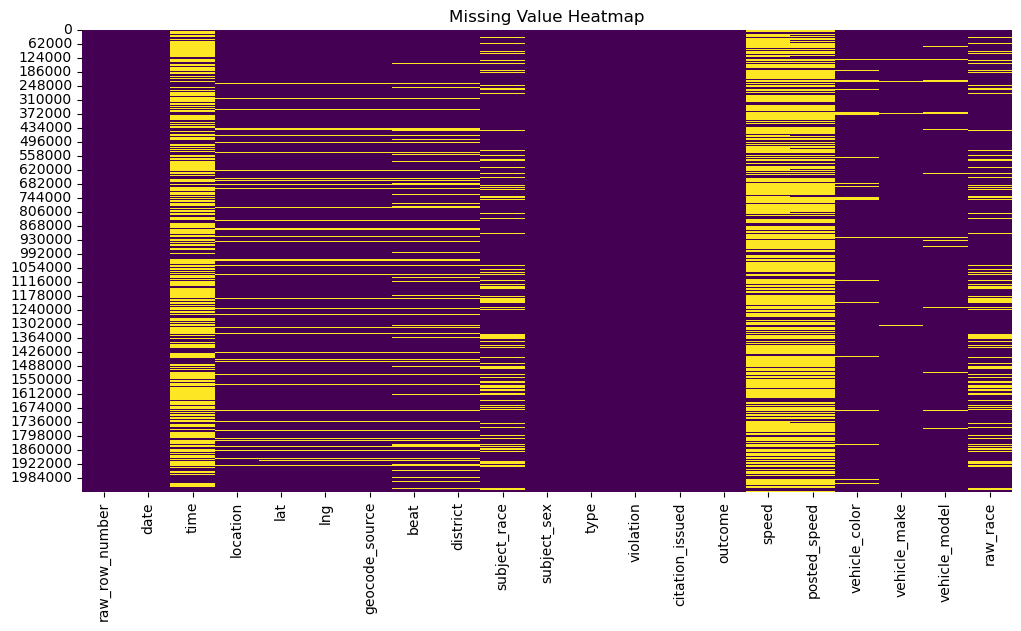

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

def perform_eda(df):
    print("===== DATA OVERVIEW =====")
    print(f"Shape: {df.shape}")
    print("\nInfo:")
    print(df.info())
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nSample Data:")
    print(df.head())

    print("\n===== STATISTICAL SUMMARY =====")
    print(df.describe(include='all').T)

    print("\n===== MISSING DATA VISUALIZATION =====")
    msno.matrix(df)
    plt.show()
    msno.bar(df)
    plt.show()

    print("\n===== DATA TYPES =====")
    print(df.dtypes.value_counts())

    # Separate numerical and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    print(f"\nNumerical columns: {num_cols}")
    print(f"Categorical columns: {cat_cols}")
    print(f"Datetime columns: {datetime_cols}")

    # Distribution plots for numerical features
    print("\n===== NUMERICAL FEATURES DISTRIBUTION =====")
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

    # Boxplots to detect outliers for numerical columns
    print("\n===== NUMERICAL FEATURES BOXPLOT (Outliers) =====")
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

    # Count plots for categorical features
    print("\n===== CATEGORICAL FEATURES COUNT PLOTS =====")
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Count Plot of {col}')
        plt.show()

    # Correlation heatmap for numerical columns
    if len(num_cols) > 1:
        print("\n===== CORRELATION HEATMAP (Numerical features) =====")
        plt.figure(figsize=(12, 8))
        corr = df[num_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title('Correlation Heatmap')
        plt.show()

    # Pairplot (scatter matrix) for first 5 numerical columns (for performance)
    if len(num_cols) >= 2:
        print("\n===== PAIRPLOT OF NUMERICAL FEATURES (first 5) =====")
        sns.pairplot(df[num_cols[:5]].dropna())
        plt.show()

    # Time series exploration if datetime columns exist
    for col in datetime_cols:
        print(f"\n===== TIME SERIES EXPLORATION: {col} =====")
        plt.figure(figsize=(12, 6))
        df.set_index(col)[num_cols].plot(subplots=True, layout=(len(num_cols), 1), figsize=(12, 4*len(num_cols)))
        plt.suptitle(f'Time Series Plot by {col}')
        plt.show()

    # Check for class imbalance if target column present (you can specify target)
    target = None  # specify your target column here if any, e.g., target = 'target_col_name'
    if target and target in df.columns:
        print(f"\n===== TARGET VARIABLE DISTRIBUTION: {target} =====")
        sns.countplot(x=target, data=df)
        plt.title(f'Distribution of Target: {target}')
        plt.show()

    print("\n===== EDA COMPLETE =====")

# Example usage:
# df = pd.read_csv('your_data.csv')
# perform_eda(df)


In [19]:
def feature_engineering(df):
    print("🛠️ Starting Feature Engineering...")
    initial_shape = df.shape
    print(f"Initial shape: {initial_shape}")

    # 1. Extract date features from datetime columns
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    if len(datetime_cols) > 0:
        print(f"Extracting features from datetime columns: {list(datetime_cols)}")
        for col in datetime_cols:
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_month'] = df[col].dt.month
            df[f'{col}_day'] = df[col].dt.day
            df[f'{col}_weekday'] = df[col].dt.weekday
            df.drop(columns=[col], inplace=True)
    else:
        print("No datetime columns found.")

    # 2. Drop highly correlated features (threshold = 0.95)
    num_df = df.select_dtypes(include=np.number)
    if not num_df.empty:
        print("Checking for highly correlated features to drop...")
        corr_matrix = num_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        if to_drop:
            print(f"Dropping highly correlated columns: {to_drop}")
            df.drop(columns=to_drop, inplace=True)
        else:
            print("No highly correlated columns found.")
    else:
        print("No numerical columns found to check correlation.")

    # 3. One-hot encode remaining categorical features (if reasonable)
    cat_cols = df.select_dtypes(include='object').columns
    if len(cat_cols) > 0:
        print(f"One-hot encoding categorical columns: {list(cat_cols)}")
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    else:
        print("No categorical columns to one-hot encode.")

    print(f"✅ Feature Engineering complete. Final shape: {df.shape}")
    return df


In [21]:
df = feature_engineering(df)


🛠️ Starting Feature Engineering...
Initial shape: (5, 5)
No datetime columns found.
Checking for highly correlated features to drop...
No highly correlated columns found.
No categorical columns to one-hot encode.
✅ Feature Engineering complete. Final shape: (5, 5)


In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def load_all_csvs_from_folders(base_folder):
    print(f"📂 Scanning for CSV files in: {base_folder}")
    all_dataframes = []

    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)
                    all_dataframes.append(df)
                    print(f"✅ Loaded: {file_path} | Shape: {df.shape}")
                except Exception as e:
                    print(f"❌ Failed to load {file_path}: {e}")

    if not all_dataframes:
        raise FileNotFoundError("No CSV files found in the directory.")

    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"📊 Total combined shape: {combined_df.shape}")
    return combined_df

def preprocess_df(df):
    print("🔧 Preprocessing data...")
    thresh = len(df) * 0.1
    df = df.dropna(axis=1, thresh=thresh)

    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
            except:
                pass

    for col in df.columns:
        dt = df[col].dtype
        if pd.api.types.is_categorical_dtype(dt):
            df[col] = df[col].cat.add_categories('Unknown')
            df[col] = df[col].fillna('Unknown')
        elif pd.api.types.is_datetime64_any_dtype(dt):
            df[col] = df[col].fillna(pd.Timestamp('1970-01-01'))
        elif pd.api.types.is_bool_dtype(dt):
            df[col] = df[col].fillna(False)
        elif pd.api.types.is_numeric_dtype(dt):
            df[col] = df[col].fillna(df[col].median())
        elif dt == 'object':
            df[col] = df[col].fillna('Unknown')

    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    for col in df.select_dtypes(include='object').columns:
        unique_vals = df[col].dropna().unique()
        types_set = set(type(v) for v in unique_vals)
        if len(unique_vals) <= 50 and (types_set <= {str} or types_set <= {int, float, np.integer, np.floating}):
            try:
                df[col] = LabelEncoder().fit_transform(df[col])
            except Exception as e:
                print(f"⚠ Could not encode column '{col}': {e}")

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        scaler = MinMaxScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])

    print("✅ Preprocessing complete.")
    return df

def feature_engineering(df):
    print("🛠 Feature engineering...")
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    for col in datetime_cols:
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_weekday'] = df[col].dt.weekday
        df.drop(columns=[col], inplace=True)

    num_df = df.select_dtypes(include=[np.number])
    if not num_df.empty:
        corr_matrix = num_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
        if to_drop:
            print(f"📉 Dropping highly correlated columns: {to_drop}")
            df.drop(columns=to_drop, inplace=True)

    cat_cols = df.select_dtypes(include='object').columns
    if len(cat_cols) > 0:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    print("✅ Feature engineering complete.")
    return df

def save_for_powerbi(df, output_path):
    print(f"💾 Saving final dataset to: {output_path}")
    df.to_csv(output_path, index=False)
    print("📊 CSV is ready for Power BI import!")

def run_pipeline(base_folder, output_csv):
    df = load_all_csvs_from_folders(base_folder)
    df = preprocess_df(df)
    df = feature_engineering(df)
    save_for_powerbi(df, output_csv)

# ✅ Correct main entry point
if __name__ == "__main__":
    # Best option: raw string
    run_pipeline(r"C:\Users\HP\Desktop\Dataset\Dataset", "final_dataset_for_powerbi.csv")



📂 Scanning for CSV files in: C:\Users\HP\Desktop\Dataset\Dataset


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_los_angeles_2020_04_01.csv | Shape: (5418402, 10)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (6,10,22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_oakland_2020_04_01.csv | Shape: (133407, 28)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_san_francisco_2020_04_01.csv | Shape: (905070, 22)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\CO\co_aurora_2023_01_26.csv | Shape: (257606, 16)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (12,14,15,20,21,22,23,24,25,27,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\IL\il_chicago_2023_01_26.csv | Shape: (2108098, 35)
✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\KY\ky_louisville_2023_01_26.csv | Shape: (146562, 33)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\MN\mn_saint_paul_2020_04_01.csv | Shape: (675156, 16)
✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\OH\oh_columbus_2020_04_01.csv | Shape: (128157, 18)


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:15: DtypeWarning: Columns (13,16,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\OK\ok_oklahoma_city_2023_01_26.csv | Shape: (945107, 27)
✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\TX\tx_austin_2020_04_01.csv | Shape: (483255, 29)
✅ Loaded: C:\Users\HP\Desktop\Dataset\Dataset\TX\tx_houston_2023_01_26.csv | Shape: (2045972, 21)
📊 Total combined shape: (13246792, 82)
🔧 Preprocessing data...


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

✅ Preprocessing complete.
🛠 Feature engineering...


C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_day'] = df[col].dt.day
C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_weekday'] = df[col].dt.weekday
C:\Users\HP\AppData\Local\Temp\ipykernel_10180\3647913533.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

MemoryError: Unable to allocate 5.13 GiB for an array with shape (104, 13246792) and data type int32

In [38]:
import os
import pandas as pd

def safe_load_and_combine_csvs(root_folder, output_csv, chunk_size=5000):
    if os.path.exists(output_csv):
        os.remove(output_csv)

    first_write = True

    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith(".csv"):
                file_path = os.path.join(dirpath, file)
                print(f"🔄 Processing: {file_path}")

                try:
                    # Try reading in chunks safely
                    chunk_iter = pd.read_csv(
                        file_path,
                        chunksize=chunk_size,
                        low_memory=True,  # Avoid dtype guessing
                        dtype=str         # Read everything as string to save memory
                    )

                    for chunk in chunk_iter:
                        # Basic cleaning: remove empty and duplicate rows
                        chunk.dropna(how='all', inplace=True)
                        chunk.drop_duplicates(inplace=True)

                        # Optional: Add filename info to track source
                        chunk['source_file'] = file

                        # Save cleaned chunk to output
                        chunk.to_csv(output_csv, mode='a', index=False, header=first_write)
                        first_write = False

                except Exception as e:
                    print(f"❌ Failed to process {file_path}: {e}")

    print(f"\n✅ Final dataset saved at: {output_csv}")

# Run it
safe_load_and_combine_csvs(
    r"C:\Users\HP\Desktop\Dataset\Dataset",
    "final_dataset_for_powerbi.csv",
    chunk_size=5000
)


🔄 Processing: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_los_angeles_2020_04_01.csv
❌ Failed to process C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_los_angeles_2020_04_01.csv: Error tokenizing data. C error: out of memory
🔄 Processing: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_oakland_2020_04_01.csv
❌ Failed to process C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_oakland_2020_04_01.csv: Error tokenizing data. C error: out of memory
🔄 Processing: C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_san_francisco_2020_04_01.csv
❌ Failed to process C:\Users\HP\Desktop\Dataset\Dataset\CA\ca_san_francisco_2020_04_01.csv: Error tokenizing data. C error: out of memory
🔄 Processing: C:\Users\HP\Desktop\Dataset\Dataset\CO\co_aurora_2023_01_26.csv
❌ Failed to process C:\Users\HP\Desktop\Dataset\Dataset\CO\co_aurora_2023_01_26.csv: Error tokenizing data. C error: out of memory
🔄 Processing: C:\Users\HP\Desktop\Dataset\Dataset\IL\il_chicago_2023_01_26.csv
❌ Failed to process C:\Users\HP\Desktop\Dataset\Dataset\IL\

In [ ]:
import os
import pandas as pd

def process_csvs_memory_safe(root_folder, output_csv, chunk_size=5000):
    if os.path.exists(output_csv):
        os.remove(output_csv)  # Start fresh
    first_write = True  # Write header only once

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                print(f"🔄 Processing: {file_path}")

                try:
                    # Use dtype=str to avoid memory-type conversion issues
                    for chunk in pd.read_csv(file_path, chunksize=chunk_size, dtype=str, low_memory=False):
                        chunk['source_file'] = file  # Optional tracking
                        chunk.dropna(how='all', inplace=True)  # Drop empty rows
                        chunk.drop_duplicates(inplace=True)    # Drop exact duplicates
                        
                        # Append to output CSV
                        chunk.to_csv(output_csv, mode='a', index=False, header=first_write)
                        first_write = False

                except Exception as e:
                    print(f"❌ Skipped {file_path} due to error: {e}")
                    continue

    print(f"\n✅ DONE: All data saved incrementally to {output_csv}")

# ▶️ Run the pipeline
process_csvs_memory_safe(
    r"C:\Users\HP\Desktop\Dataset\Dataset",
    "final_dataset_for_powerbi.csv",
    chunk_size=5000  # You can reduce to 1000 if RAM is very low
)


In [ ]:
final_dataset_for_powerbi.csv


In [ ]:
import os
print(os.getcwd())  # To know where it's saving the file
